In [42]:
import parflow as pf
import plotly.express as px
import matplotlib as mpl
import matplotlib.pyplot as plot
import os.path, time
import pandas as pd
import seaborn as sns
import numpy as np

If you have not run through run_ensemble.ipynb, you will need to do that before running this notebook

First we need to define a couple functions for later

In [45]:
def calculate_run_times(reservoir_amounts, rain_condition, reservoir_condition):
    run_times = {}
    # run_times["preprocessing"] = {}
    run_times["first_time_step"] = {}
    run_times["second_time_step"] = {}
    run_times["rest_of_simulation"] = {}
    for amount in reservoir_amounts:
        folder = f"./test_output_longer_run/sloping_slab_with_{amount}_reservoirs_{reservoir_condition}_{rain_condition}"
        # preprocessing_start_file = f"{folder}/model.pfidb"
        # preprocessing_start_time = os.path.getctime(preprocessing_start_file)
        simulation_start_file = f"{folder}/model.out.press.00000.pfb"
        simulation_start_time = os.path.getctime(simulation_start_file)
        first_timestep_file = f"{folder}/model.out.press.00001.pfb"
        first_timestep_time = os.path.getctime(first_timestep_file)
        second_timestep_file = f"{folder}/model.out.press.00002.pfb"
        second_timestep_time = os.path.getctime(second_timestep_file)
        simulation_end_file = f"{folder}/model.out.press.00010.pfb"
        simulation_end_time = os.path.getctime(simulation_end_file)
        # run_times["preprocessing"][amount] = (simulation_start_time-preprocessing_start_time)
        run_times["first_time_step"][amount] = (first_timestep_time-simulation_start_time)
        run_times["second_time_step"][amount] = (second_timestep_time-first_timestep_time)
        run_times["rest_of_simulation"][amount] = (simulation_end_time-second_timestep_time)
    return pd.DataFrame(run_times)



In [46]:
def get_surface_pressure(rain_condition, reservoir_condition):
    amount = 10000
    folder = f"./test_output_longer_run/sloping_slab_with_{amount}_reservoirs_{reservoir_condition}_{rain_condition}"
    pressure_file = f"{folder}/model.out.press.00010.pfb"
    pressure = pf.read_pfb(pressure_file)
    return pressure

In [47]:

def get_reservoir_mask(reservoir_file):
    df = pd.read_csv(reservoir_file)
    dx = 10.0
    dy = 10.0
    df.Intake_X = (df.Intake_X/dx).astype(int)
    df.Intake_Y = (df.Intake_Y/dy).astype(int)
    reservoir_mask = np.zeros([500,500])
    for reservoir in range(0,10000):
        reservoir_mask[df.Intake_Y[reservoir], df.Intake_X[reservoir]] = 1
    return reservoir_mask

reservoirs_releasing_mask = get_reservoir_mask("reservoir_files/10000_reservoirs_releasing.csv")
reservoirs_not_releasing_mask = get_reservoir_mask("reservoir_files/10000_reservoirs_not_releasing.csv")


Next we tabulate some statistics

In [ ]:

#for the sake of your time we are not running for 10000 reservoirs but if you would like to you 
# can uncomment this and then comment out the next line
# reservoir_amounts = [0,1,10,100,1000,10000]
reservoir_amounts = [0,1,10,100,1000]

rain_condition = "constant_rain"
reservoir_condition = "not_releasing"
filling_runtimes = calculate_run_times(reservoir_amounts, rain_condition, reservoir_condition)
filling_pressure = get_surface_pressure(rain_condition, reservoir_condition)
# filling_pressure = np.where(reservoirs_not_releasing_mask==1, np.nan, filling_pressure)

rain_condition = "no_rain"
reservoir_condition = "releasing"
draining_runtimes = calculate_run_times(reservoir_amounts, rain_condition, reservoir_condition)
draining_pressure = get_surface_pressure(rain_condition, reservoir_condition)
# draining_pressure = np.where(reservoirs_releasing_mask==1, np.nan, filling_pressure)

rain_condition = "periodic_rainfall"
reservoir_condition = "releasing"
periodic_rainfall_runtimes = calculate_run_times(reservoir_amounts, rain_condition, reservoir_condition)
periodic_rainfall_pressure = get_surface_pressure(rain_condition, reservoir_condition)
# periodic_rainfall_pressure = np.where(reservoirs_releasing_mask==1, np.nan, filling_pressure)

In [49]:
filling_runtimes

,first_time_step,second_time_step,rest_of_simulation
0,194.156713,98.912808,95.558401
1,219.581569,134.749656,301.946579
10,230.632705,145.892955,319.304050
100,228.025173,137.336358,347.272105
1000,221.103928,129.787269,348.828757


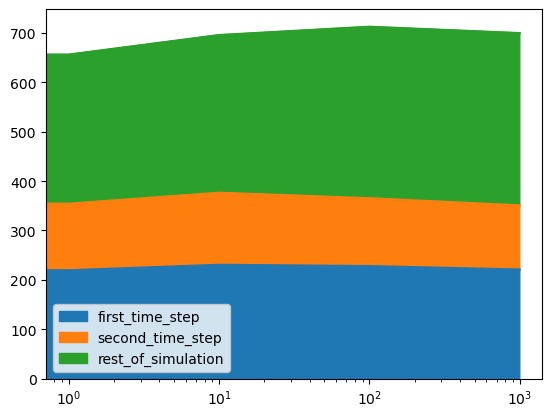

In [50]:
filling_runtimes.plot.area( logx=True)
mpl.style.use('seaborn-v0_8-colorblind')

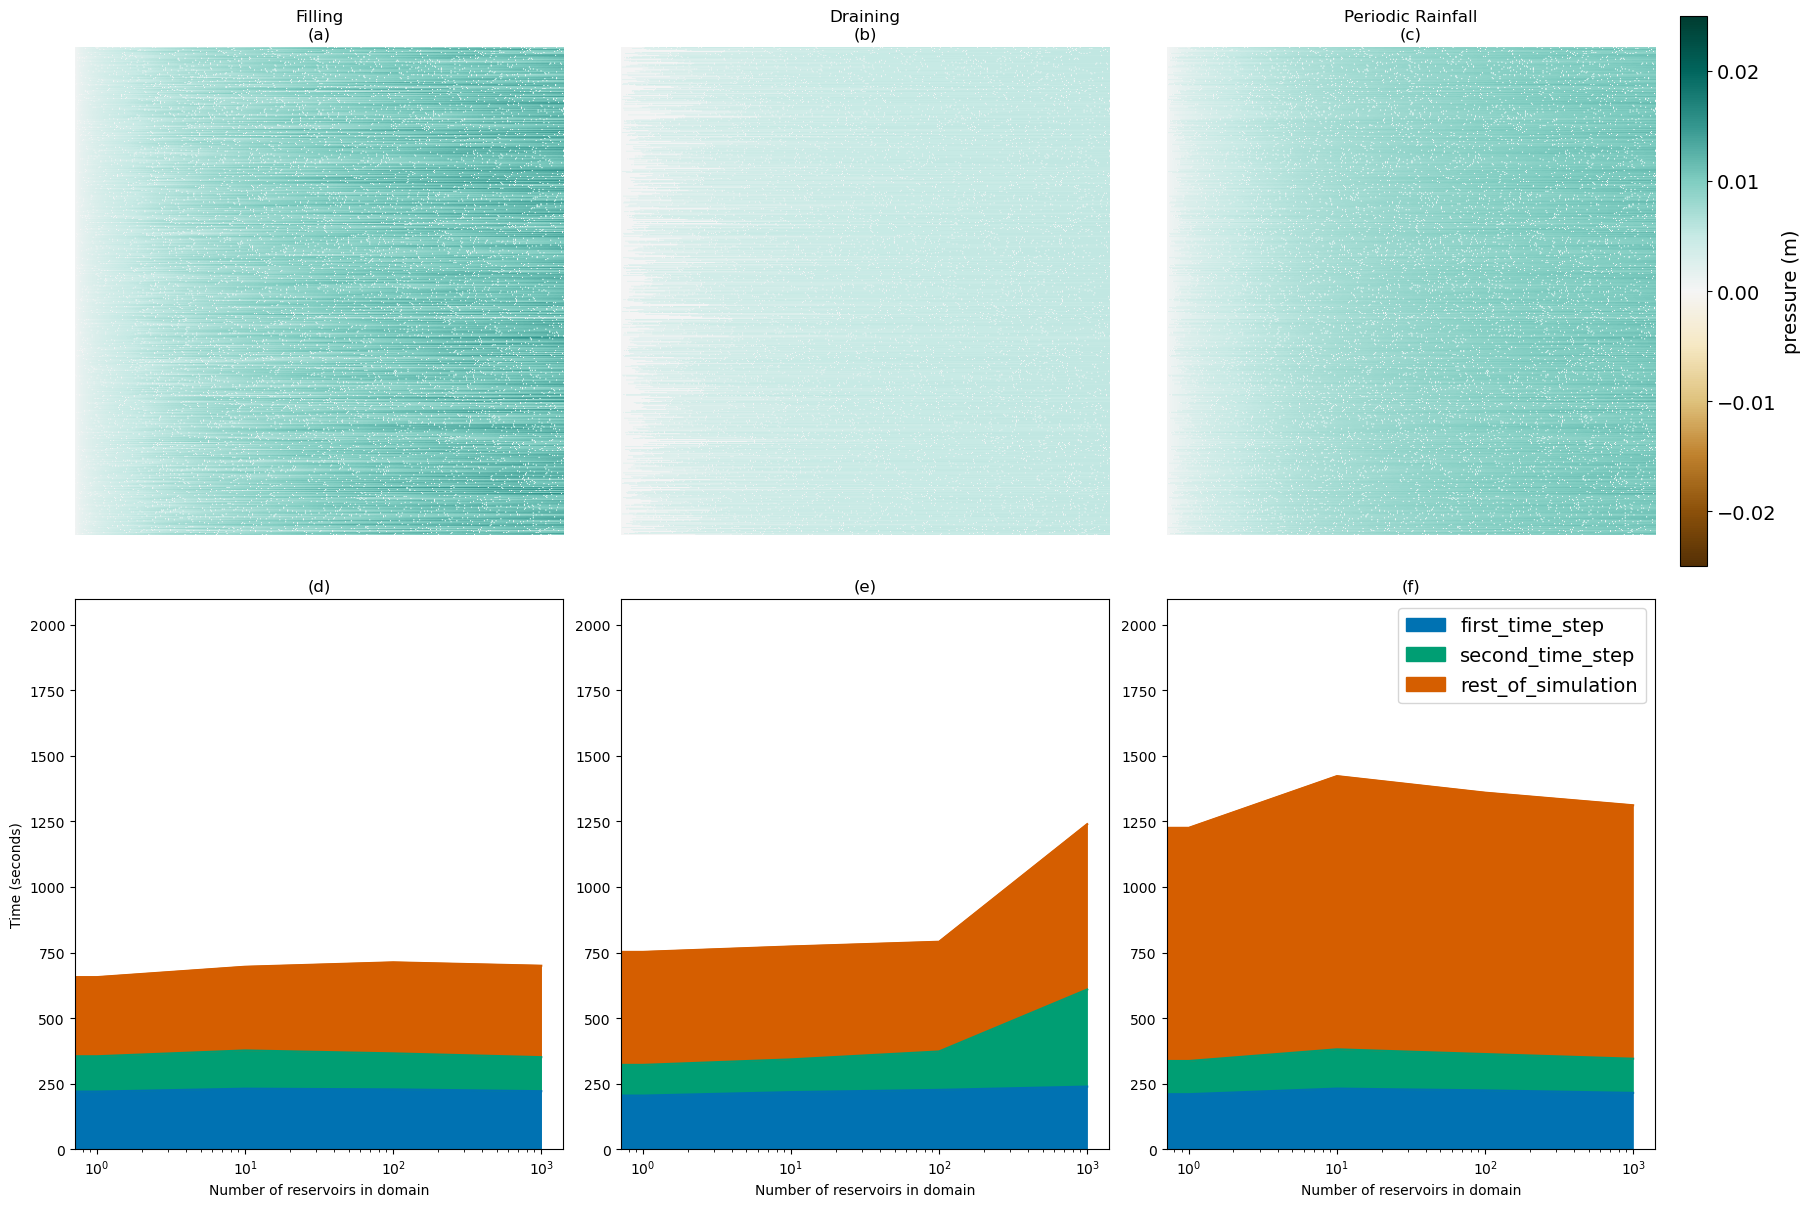

In [ ]:
fig, axes = plot.subplots(2, 3, layout='constrained')
fig.set_figheight(12)
fig.set_figwidth(18)
plot.rcParams.update({'font.size': 14})
cmap = mpl.pyplot.get_cmap("BrBG")
# cmap.set_bad(color="grey")



filling_runtimes.plot.area( logx=True, ax = axes[1,0], legend=False, ylim=[0,2100])
axes[1,0].set_ylabel("Time (seconds)")
axes[1,0].set_xlabel("Number of reservoirs in domain")
draining_runtimes.plot.area( logx=True, ax = axes[1,1], legend=False, ylim=[0,2100])
axes[1,1].set_xlabel("Number of reservoirs in domain")
periodic_rainfall_runtimes.plot.area( logx=True, ax = axes[1,2], legend=True, ylim=[0,2100])
axes[1,2].set_xlabel("Number of reservoirs in domain")

filling_image =  axes[0,0].imshow(filling_pressure[0], vmin=-0.025, vmax=0.025, cmap=cmap)
axes[0,0].grid(False)
axes[0,0].axis('off')

draining_image = axes[0,1].imshow(draining_pressure[0], vmin=-0.025, vmax=0.025, cmap=cmap)
axes[0,1].grid(False)
axes[0,1].axis('off')

periodic_rainfall_image = axes[0,2].imshow(periodic_rainfall_pressure[0], vmin=-0.025, vmax=0.025, cmap=cmap)
axes[0,2].grid(False)
axes[0,2].axis('off')
colobar = plot.colorbar(periodic_rainfall_image, label="pressure (m)")



axes[0,0].title.set_text("Filling\n(a)")
axes[0,1].title.set_text("Draining\n(b)")
axes[0,2].title.set_text("Periodic Rainfall\n(c)")

axes[1,0].title.set_text("(d)")
axes[1,1].title.set_text("(e)")
axes[1,2].title.set_text("(f)")